In [1]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, AncillaRegister

In [2]:
def triple_controlled_not():
    ctrl_qreg = QuantumRegister(3, 'ctrl')
    x_qreg = QuantumRegister(1, 'x')
    g_qreg = AncillaRegister(1, 'g')

    circuit = QuantumCircuit(ctrl_qreg, x_qreg, g_qreg, name='CCCX')

    for _ in range(2):
        circuit.ccx(ctrl_qreg[0], ctrl_qreg[1], g_qreg[0])
        circuit.ccx(ctrl_qreg[2], g_qreg[0], x_qreg[0])

    return circuit.to_gate()

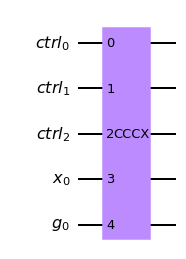

In [3]:
_qrCtrl = QuantumRegister(3, name='ctrl')
_qrX = QuantumRegister(1, name='x')
_qrG = QuantumRegister(1, name='g')
_qc = QuantumCircuit(_qrCtrl, _qrX, _qrG)

cccx = triple_controlled_not()
_qc.append(cccx, _qrCtrl[:] + _qrX[:] + _qrG[:])
_qc.draw(output='mpl')

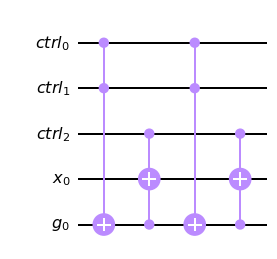

In [4]:
_dec = _qc.decompose()
_dec.draw(output='mpl')

In [15]:
def get_bits(x, n):
    return [int(x) for x in '{:0{size}b}'.format(x, size=n)]

In [16]:
def init(ctrl, x, g):
    n = 3
    
    qrCtrl = QuantumRegister(n, name='ctrl')
    qrX = QuantumRegister(1, name='x')
    qrG = QuantumRegister(1, name='g')
    qc = QuantumCircuit(qrCtrl, qrX, qrG)
    
    
    ctrl_bits = get_bits(ctrl, n)
    for i in range(n):
        if ctrl_bits[n-(i+1)] == 1:
            qc.x(qrCtrl[i])
    
    if x == 1:
        qc.x(qrX[0])
                
    if g == 1:
        qc.x(qrG[0])

    qc.barrier(qrCtrl[:], qrX[:], qrG[:])
        
    return qc

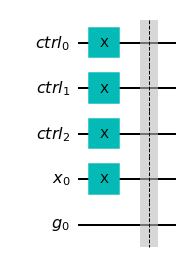

In [17]:
init(7, 1, 0).draw(output='mpl')

In [18]:
def measure():
    qrX = QuantumRegister(1, name='x')
    qrG = QuantumRegister(1, name='g')
    
    crX = ClassicalRegister(1, name='xValue')
    crG = ClassicalRegister(1, name='gValue')
    
    qc = QuantumCircuit(qrX, qrG, crX, crG)
    qc.barrier(qrX[:], qrG[:])
    
    qc.measure(qrX[:], crX[:])
    qc.measure(qrG[:], crG[:])
    
    return qc

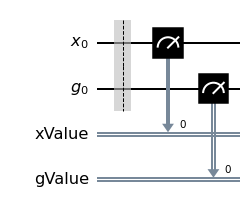

In [19]:
measure().draw(output='mpl')

In [20]:
def test_triple_controlled_negation(ctrl, x, value):
    expected_value = (x + 1) % 2 if ctrl == 7 else x
    print(expected_value, value, expected_value == value)

In [21]:
test_triple_controlled_negation(7, 1, 0)

0 0 True


In [22]:
from qiskit import Aer
from qiskit import execute

backend = Aer.get_backend('qasm_simulator')

In [26]:
def test(ctrl, x, g):
    qrCtrl = QuantumRegister(3, name='ctrl')
    qrX = QuantumRegister(1, name='x')
    qrG = QuantumRegister(1, name='g')
    
    qc = QuantumCircuit(qrCtrl, qrX, qrG)
        
    qc += init(ctrl, x, g)
    
    qc.append(
        triple_controlled_not(),
        qrCtrl[:] + qrX[:] + qrG[:]
    )
        
    qc += measure()

    job = execute(qc, backend, shots=1)
    result = job.result()
    values = list(result.get_counts(qc).keys())

    assert len(values) == 1
    values = [int(v, 2) for v in values[0].split(' ')]

    g_value = values[0]
    x_value = values[1]

    print(g, g_value, g == g_value)
    test_triple_controlled_negation(ctrl, x, x_value)
        
    return qc

In [27]:
_qc = test(7, 1, 0)

0 0 True
0 0 True


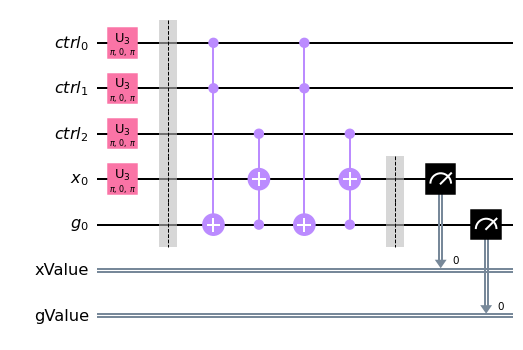

In [28]:
_dec = _qc.decompose()
_dec.draw(output='mpl')

In [ ]:
# for ctrl in reversed(range(8)):
#     for x in range(2):
#         for g in range(2):
#             print('---', ctrl, '-', x, g, '---')
#             test(ctrl, x, g)